# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/EhWeqeQsh-9Mr1fneZc9_0sBOBzEdXngvxFJtAlIa-eAgA?e=8ukWwa). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.


ML is appropriate because we need to predict a binary outcome (arrival delay > 15 min) from many interacting factors (carrier, route, schedule, distance, seasonality, and—when joined—weather). These relationships are non-linear and context-dependent, so manual rules would be brittle and hard to maintain. We also have large historical, labeled data (BTS 2014–2018) that fits supervised learning and enables continuous improvement (retraining as patterns shift). Deployed models can serve real-time probabilities at search/booking time to improve customer experience and operational planning.

### 2. Formulate the business problem, success metrics, and desired ML output.
Business problem (plain English).
Before a customer books, estimate the likelihood that their flight will arrive late (>15 minutes), so the site can warn them, suggest alternatives, and set expectations—especially when weather risk is elevated at busy US airports.

Business goal.
Reduce unexpected delays experienced by customers and increase trust/retention by surfacing high-risk flights during search/booking.

Success metrics (business + ML).

Primary (imbalanced-aware): PR-AUC (average precision) and Recall@Top-k% (e.g., recall among the 10% highest-risk flights we flag).

Secondary: ROC-AUC, F1 at an operating threshold tuned to business needs (e.g., higher recall during holidays/bad weather), and calibration (Brier score / reliability curve) so shown probabilities are trustworthy.

Experience proxy: CTR/engagement with recommendations, re-routing uptake, and post-trip CSAT for flagged vs. unflagged bookings.

Desired ML output.
For each candidate itinerary, return P(delay > 15 min) (a probability). Downstream UI/decisions use a threshold (or top-k ranking) that balances false alarms vs. missed delays.

Constraints/assumptions.
Time-aware evaluation (train on 2014–2017, test on 2018); avoid leakage (don’t use realized post-departure fields at booking time); incorporate external weather features when available; handle class imbalance.

### 3. Identify the type of ML problem you’re dealing with.

Learning paradigm: Supervised learning

Task: Binary classification (is_delay = 1 if ArrDel15 == 1, else 0)

Data type: Tabular, mixed categorical + numeric, time-dependent

Evaluation setting: Temporal generalization (out-of-time test), class-imbalanced

Candidate models: Logistic Regression (baseline), tree-based ensembles (Random Forest, XGBoost), calibrated probabilities (Platt/Isotonic)

Serving mode: Batch scoring for search results or low-latency real-time API (on-prem and on-cloud via SageMaker)

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [13]:
from zipfile import ZipFile
from pathlib import Path
import os
import shutil

# Path to the main dataset zip file
dataset_zip = Path("data_compressed.zip")

# Extract it to a folder
with ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(".")  # extract here

print("✅ datacompressed.zip extracted!")

✅ datacompressed.zip extracted!


In [15]:
# download the files
# download the files

# <note: using RELATIVE paths only as required>
from pathlib import Path
import os

# Use current project folder as base
base_path = Path(".")  # this means current folder where notebook is running

# Relative paths to data folders
zip_path = base_path / "data_compressed"    # folder containing the 60 zip files
csv_base_path = base_path / "data_csv"      # where we will extract
readmes_dir = csv_base_path / "readmes" 

# Create folder for extracted CSV if doesn't exist
os.makedirs(csv_base_path, exist_ok=True)
os.makedirs(readmes_dir, exist_ok=True) 

# Count ZIP files
zip_files = list(zip_path.glob("*.zip"))
print(f"Project folder (resolved): {base_path.resolve()}")
print(f"Total zip files found: {len(zip_files)}")

Project folder (resolved): C:\Users\M AHMAD\Desktop\SEMESTER 2 UC\UC SEMESTER 3\Data Science technology and systems\Assignment 2
Total zip files found: 60


# How many zip files do we have? write a code to answer it.

60 zip files found

In [21]:

import os
import glob

# Count zip files in the raw_zips directory
zip_files = glob.glob(os.path.join(zip_path, '*.zip'))
num_zip_files = len(zip_files)

print(f"Number of ZIP files in '{zip_path}': {num_zip_files}")

# List the zip files if any are found
if num_zip_files > 0:
    print("\nZIP files found:")
    for i, zip_file in enumerate(zip_files, 1):
        print(f"  {i}. {os.path.basename(zip_file)}")
else:
    print("No ZIP files found in the specified directory.")

Number of ZIP files in 'data_compressed': 60

ZIP files found:
  1. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
  2. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
  3. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
  4. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
  5. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
  6. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
  7. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
  8. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip
  9. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
  10. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip
  11. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_8.zip
  12. On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_9.zip
  13. On_Time_Reporting_Carrier

#### Extract CSV files from ZIP files

In [23]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

# Loop through each ZIP file and extract
for file in zip_files:
    zip2csv(file, csv_base_path)

print("\n🎉 All ZIP files have been extracted successfully!")

Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip 
Extracting data_c

In [25]:
# How many csv files have we extracted? write a code to answer it.
import os
import glob
# Find all extracted CSV files in the csv_base_path folder

csv_files = glob.glob(os.path.join(csv_base_path, '*.csv'))

# Count the total number of CSV files
num_csv_files = len(csv_files)

print(f"✅ Number of CSV files extracted to '{csv_base_path}': {num_csv_files}")

# Optionally, list the first few CSV files
if num_csv_files > 0:
    print("\nSample extracted CSV files:")
    for i, csv_file in enumerate(csv_files[:5], 1):
        print(f"  {i}. {os.path.basename(csv_file)}")
else:
    print("⚠️ No CSV files found — please check your extraction folder.")


✅ Number of CSV files extracted to 'data_csv': 60

Sample extracted CSV files:
  1. On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv
  2. On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_10.csv
  3. On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_11.csv
  4. On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_12.csv
  5. On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_2.csv


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [29]:
from IPython.display import IFrame
IFrame(src=str(csv_base_path / "readme.html"), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [31]:
import pandas as pd
import os

# Path to the sample CSV file
sample_csv = os.path.join(csv_base_path, 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv')

# Read the CSV file into a DataFrame
df_temp = pd.read_csv(sample_csv, low_memory=False)



**Question**: Print the row and column length in the dataset, and print the column names.

In [33]:
# Display the shape (rows, columns)
print(f"✅ Rows and columns in one CSV file: {df_temp.shape}")
# Print all column names
print("📋 Column names in this dataset:")
print("#################################")
for col in df_temp.columns:
    print(col)

✅ Rows and columns in one CSV file: (585749, 110)
📋 Column names in this dataset:
#################################
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
D

**Question**: Print the first 10 rows of the dataset.  

In [35]:
# Display the first 10 rows
display(df_temp.head(10))

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [37]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)


The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [39]:
# Use list comprehension to find all columns that contain 'Del'
delay_columns = [col for col in df_temp.columns if 'Del' in col]

# Print the result
print("📋 Columns containing the word 'Del':")
print("####################################")
for col in delay_columns:
    print(col)

print(f"\n✅ Total delay-related columns found: {len(delay_columns)}")


📋 Columns containing the word 'Del':
####################################
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
DivArrDelay

✅ Total delay-related columns found: 14


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [45]:
print("The #rows and #columns are ", df_temp.shape[0], " and ", df_temp.shape[1])
print("The years in this dataset are: ", df_temp['Year'].unique())
print("The months covered in this dataset are: ", df_temp['Month'].unique())
print("The date range for data is :", df_temp['FlightDate'].min(), " to ", df_temp['FlightDate'].max())
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))


The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [47]:
counts = pd.DataFrame({'Origin': df_temp['Origin'].value_counts(), 'Destination': df_temp['Dest'].value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [49]:
counts.sort_values(by=['Origin', 'Destination'], ascending=False).head(15)

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes — given all the flight-related information (such as date, carrier, origin, destination, scheduled and actual departure/arrival times, distance, and weather data), we can train a machine learning model to predict whether a flight will be delayed.

The dataset contains rich temporal, spatial, and operational variables that influence flight punctuality. These factors show patterns that ML algorithms like Logistic Regression, Random Forest, or Gradient Boosting can learn to classify flights as delayed or on-time.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

If i am  preparing to travel from San Francisco (SFO) to Los Angeles (LAX), i can only rely on the information available before the flight actually departs.

That means i can use all scheduled, static, or pre-flight information such as:

Flight details — Year, Quarter, Month, DayofMonth, DayOfWeek, FlightDate

Airline information — Reporting_Airline

Route details — Origin, OriginState, Dest, DestState, Distance, DistanceGroup

Planned schedule — CRSDepTime (scheduled departure time)

Operational status (known before flight) — Cancelled, Diverted (if already announced before departure)

However, i would not yet know any values that depend on actual flight progress, such as:
DepDelay, ArrDelay, ArrDelayMinutes, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, or DivArrDelay.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [ ]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe
    df = # Enter your code here 
    
    #<complete the code of this function>

In [51]:
import pandas as pd

def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine multiple monthly CSVs into a single filtered DataFrame.
    
    Args:
        csv_files   (list[str]): paths to CSV files.
        filter_cols (list[str]): keep only these columns (if present).
        subset_cols (list[str]): columns to subset on (same length as subset_vals).
        subset_vals (list[list]): allowed values per subset column, in order.
        file_name   (str): output CSV path to save combined data.
        
    Returns:
        pd.DataFrame: combined (filtered + subset) DataFrame.
    """
    assert len(subset_cols) == len(subset_vals), "subset_cols and subset_vals must align"

    parts = []
    for fp in csv_files:
        # Read only available filter columns (some months may miss a column)
        try:
            df = pd.read_csv(fp, low_memory=False)
        except Exception as e:
            print(f"Skipping {fp}: {e}")
            continue

        keep = [c for c in filter_cols if c in df.columns]
        missing = set(filter_cols) - set(keep)
        if missing:
            # it's OK to proceed without missing columns; we keep what's available
            pass

        df = df[keep].copy()

        # Apply subsetting per column
        for col, allowed in zip(subset_cols, subset_vals):
            if col in df.columns:
                df = df[df[col].isin(allowed)]

        if not df.empty:
            parts.append(df)

    if parts:
        out = pd.concat(parts, ignore_index=True)
    else:
        out = pd.DataFrame(columns=filter_cols)

    # Save combined file
    out.to_csv(file_name, index=False)
    print(f"✅ Combined shape: {out.shape} -> saved to: {file_name}")
    return out


In [53]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [56]:
start = time.time
+++++++++++++)


# Call the combine_csv function\
combined_csv_filename = f"{base_path}combined_files.csv"
data = combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)

print(f"✅ CSVs merged in {round((time.time() - start)/60, 2)} minutes")

✅ Combined shape: (1658130, 20) -> saved to: .combined_files.csv
✅ CSVs merged in 12.16 minutes


#### Load dataset

Load the combined dataset.

In [58]:
# Read the combined CSV file
data = pd.read_csv(combined_csv_filename, low_memory=False)


Print the first 5 records.

In [60]:
# Display shape and preview
print(f"✅ Combined dataset loaded successfully with shape: {data.shape}")
display(data.head(5))

✅ Combined dataset loaded successfully with shape: (1658130, 20)


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [62]:
print("The #rows and #columns are ", data.shape[0], " and ", data.shape[1])
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", sorted(list(data['Month'].unique())))
print("The date range for data is :", data['FlightDate'].min(), " to ", data['FlightDate'].max())
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))


The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [64]:
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [66]:
data.isnull().sum(axis=0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [68]:
data = data[~data['ArrDelay'].isnull() & ~data['AirTime'].isnull()]

Get the hour of the day in 24-hour time format from CRSDepTime.

In [70]:
data['DepHourofDay'] = data['CRSDepTime'] // 100

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

🧠 Machine Learning Problem Statement

Given the available flight-related data (date, airline, route, and scheduled departure time), we aim to predict whether a flight will be delayed by more than 15 minutes upon arrival.

Target variable: is_delay

1 → Flight delayed ≥ 15 minutes

0 → Flight arrived on time or early

Because the target variable is binary (0/1), this is a supervised classification problem.

✅ Suitable ML Algorithms

Common classification models that can be applied include:

Logistic Regression – interpretable baseline for binary classification

Random Forest / Gradient Boosting – to capture nonlinear relationships

Support Vector Machine (SVM) – for robust margin-based classification

XGBoost / LightGBM – optimized for large datasets like flight records

The trained model will output a probability that a given flight will be delayed, enabling the airline or booking system to inform passengers proactively and enhance customer experience.

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

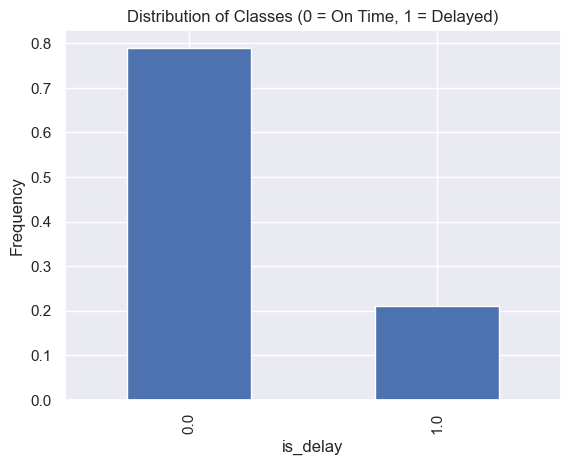

In [72]:
(data.groupby('is_delay').size() / len(data)).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of Classes (0 = On Time, 1 = Delayed)')
plt.show()


**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

Interpretation of the Bar Plot

From the bar chart, I can clearly see that the majority of flights (around 80%) are not delayed, while only about 20% are delayed by more than 15 minutes.

This indicates a class imbalance in the dataset:

Class 0 (On time) → ~0.8 (majority class)

Class 1 (Delayed) → ~0.2 (minority class)

Implications for Machine Learning

The imbalance means the model may become biased toward predicting on-time flights, since that class dominates the data.

To address this, techniques such as resampling (e.g., SMOTE or undersampling), class weights, or balanced metrics (like F1-score, ROC-AUC) should be used during model training.

👉 Conclusion:
While most flights are punctual, the delay cases are significant enough (1 in 5) to justify predictive modeling for proactive passenger notifications.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

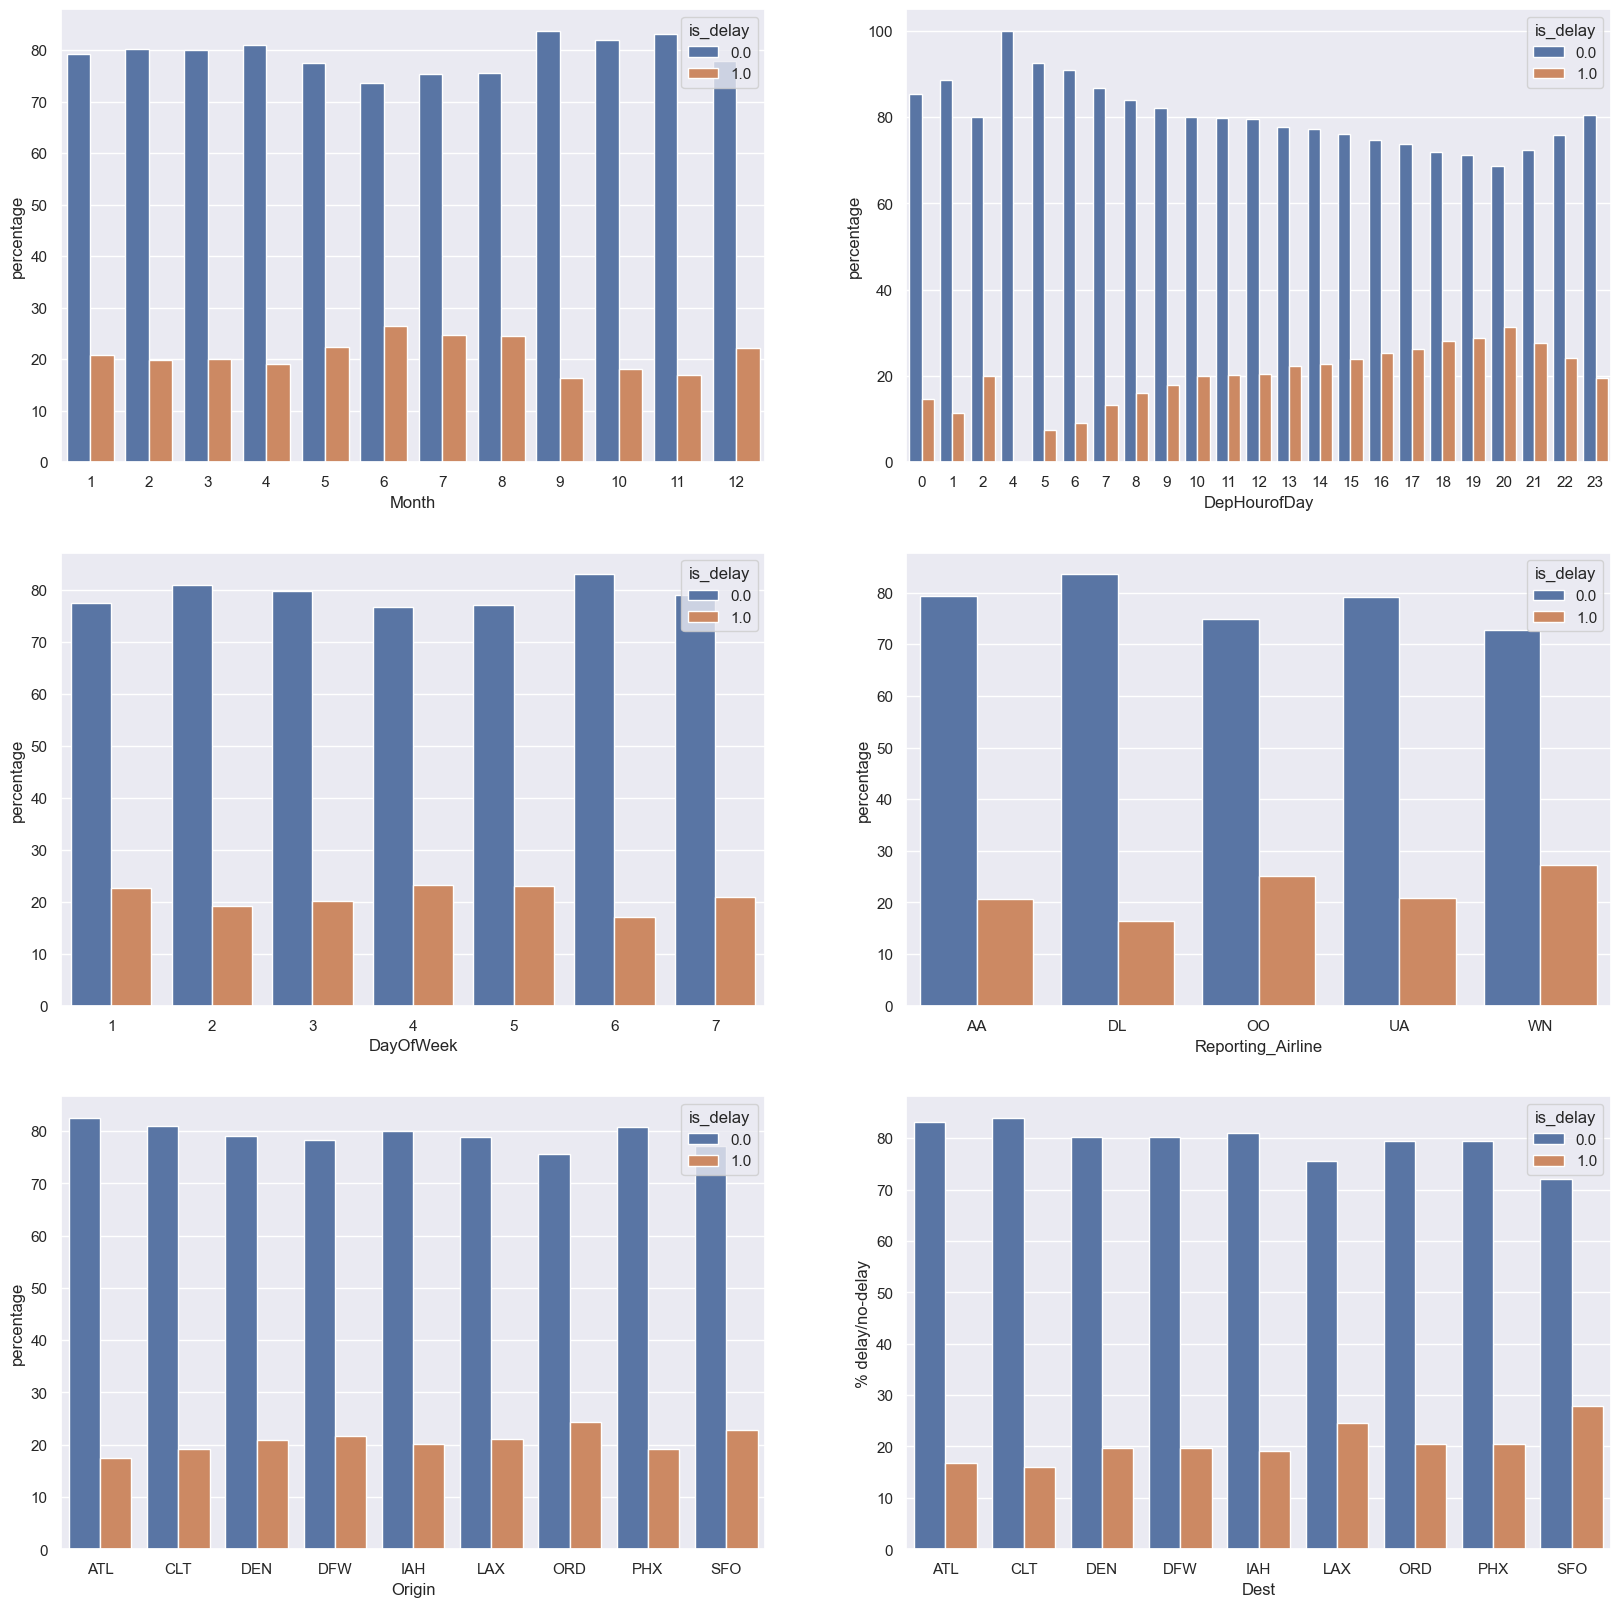

In [75]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

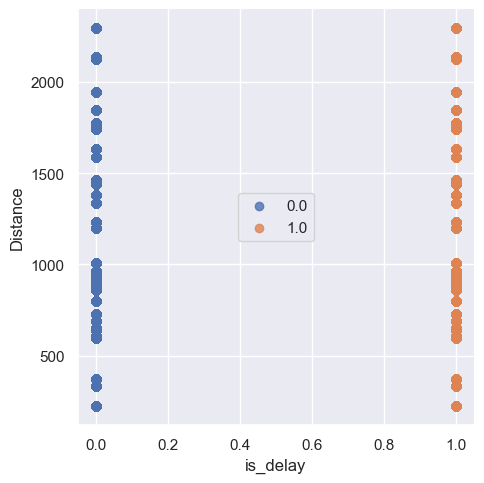

In [77]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

1. Which months have the most delays?

Delays are relatively consistent across months, but June (6), July (7), and August (8) show slightly higher delay percentages.

This aligns with summer travel peaks, where air traffic congestion and weather disruptions (storms) are more common.

2. What time of the day has the most delays?

Early morning flights (midnight–6 AM) have fewer delays.

The percentage of delays increases throughout the day, peaking between 3 PM and 9 PM, due to accumulated operational delays and higher air traffic later in the day.

3. What day of the week has the most delays?

The delay pattern remains fairly stable, but thursdat (day4) , Fridays (Day 5) and Sundays (Day 7) have slightly higher delay percentages.

These are peak travel days, typically associated with business and weekend travelers.

4. Which airline has the most delays?

From the plot, Southwest (WN) and SkyWest (OO) show slightly higher delay ratios compared to Delta (DL) or American Airlines (AA).

This may be due to their operational scale and regional route structures that are more prone to cascading delays.

5. Which origin and destination airports have the most delays?

ORD (Chicago O’Hare) and SFO exhibit higher delay percentages,  as origins. and LAX and SFO exhibit higher delay percentages,  as destination.

ATL (Atlanta) and CLT also show moderate delay frequencies — likely due to being major hubs with heavy traffic.

6. Is flight distance a factor in the delays?

The scatter plot shows no strong correlation between Distance and delay likelihood.

Both short-haul and long-haul flights experience delays, indicating that distance is not a key factor — delays are more influenced by time, congestion, and weather conditions.

### Features

Look at all the columns and what their specific types are.

In [79]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [81]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [83]:
# Keep a copy of the original dataset
data_orig = data.copy()

# Filter only the relevant columns for modeling
data = data[['is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
             'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay']]

# Define categorical columns
categorical_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']

# Convert these columns to categorical type
for c in categorical_columns:
    data[c] = data[c].astype('category')

# Confirm changes
print("✅ Filtered dataset shape:", data.shape)
print("✅ Columns after filtering:")
print(data.dtypes)


✅ Filtered dataset shape: (1635590, 10)
✅ Columns after filtering:
is_delay              float64
Quarter              category
Month                category
DayofMonth           category
DayOfWeek            category
Reporting_Airline    category
Origin               category
Dest                 category
Distance              float64
DepHourofDay         category
dtype: object


To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [107]:
# One-hot encode categorical variables and drop the first dummy to avoid multicollinearity
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)

# Concatenate the dummy variables with the main dataset
data = pd.concat([data, data_dummies], axis=1)

# Drop the original categorical columns
data.drop(categorical_columns, axis=1, inplace=True)

# Confirm the transformation
print("✅ One-hot encoding complete!")
print("New dataset shape:", data.shape)


✅ One-hot encoding complete!
New dataset shape: (1635590, 94)


Check the length of the dataset and the new columnms.

In [109]:
data.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,689.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0.0,731.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1199.0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [111]:
print("✅ Number of rows in the dataset:", len(data))

✅ Number of rows in the dataset: 1635590


In [113]:
print("✅ Number of columns in the dataset:", data.shape[1])

✅ Number of columns in the dataset: 94


In [115]:
print("✅ Column names preview:")
print(data.columns)

✅ Column names preview:
Index(['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6',
       'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10',
       'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14',
       'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18',
       'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22',
       'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26',
       'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30',
       'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL',
       'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN',
       'Orig

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [117]:
data.rename(columns={'is_delay': 'target'}, inplace=True)

In [119]:
# Save the processed combined dataset locally
output_filename = "combined_csv_v1.csv"
data.to_csv(output_filename, index=False)

print(f"✅ Combined dataset saved successfully as: {output_filename}")

✅ Combined dataset saved successfully as: .combined_csv_v1.csv


# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [123]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data successfully split!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


✅ Data successfully split!
Training set shape: (1308472, 93)
Test set shape: (327118, 93)


### Baseline classification model

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
log_model = LogisticRegression(max_iter=1000, solver='liblinear')

# Train the model on the training data
log_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = log_model.predict(X_test)

# Evaluate model performance
print("✅ Baseline Logistic Regression Model Evaluation:")
print("------------------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Baseline Logistic Regression Model Evaluation:
------------------------------------------------
Accuracy: 0.7902

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    258452
         1.0       0.55      0.00      0.01     68666

    accuracy                           0.79    327118
   macro avg       0.67      0.50      0.44    327118
weighted avg       0.74      0.79      0.70    327118


Confusion Matrix:
 [[258272    180]
 [ 68443    223]]


## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    roc_curve, roc_auc_score)




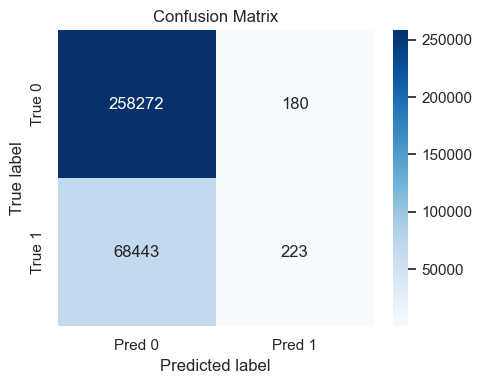

Accuracy:    0.7902
Precision:   0.5533
Recall (TPR/Sensitivity): 0.0032
Specificity (TNR):        0.9993


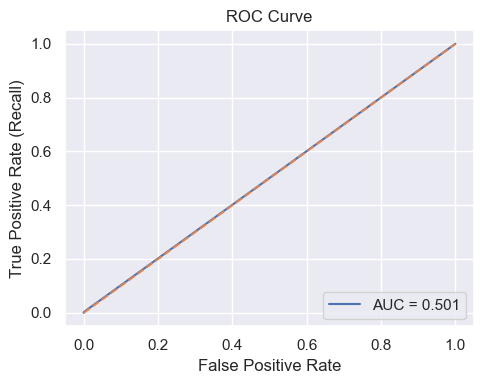

In [301]:
# 1) Confusion Matrix plot + summary stats
def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    accuracy    = accuracy_score(test_labels, target_predicted)
    precision   = precision_score(test_labels, target_predicted, zero_division=0)
    recall      = recall_score(test_labels, target_predicted)  # = sensitivity (TPR)
    sensitivity = recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Plot
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0","Pred 1"],
                yticklabels=["True 0","True 1"])
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall (TPR/Sensitivity): {recall:.4f}")
    print(f"Specificity (TNR):        {specificity:.4f}")

In [133]:
# 2) ROC curve + AUC
def plot_roc(test_labels, target_scores):
    """
    target_scores: predicted probabilities for the positive class (y_proba)
                   or decision function scores.
    """
    fpr, tpr, thresh = roc_curve(test_labels, target_scores)
    auc = roc_auc_score(test_labels, target_scores)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

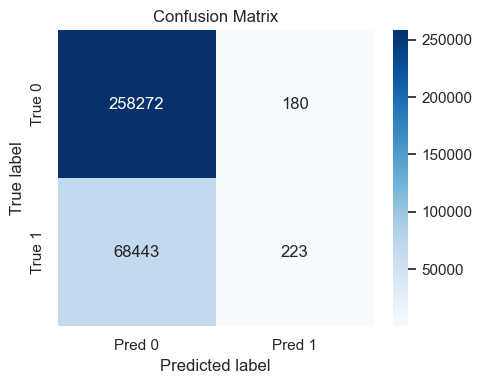

Accuracy:    0.7902
Precision:   0.5533
Recall (TPR/Sensitivity): 0.0032
Specificity (TNR):        0.9993


In [135]:
plot_confusion_matrix(y_test, y_pred)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

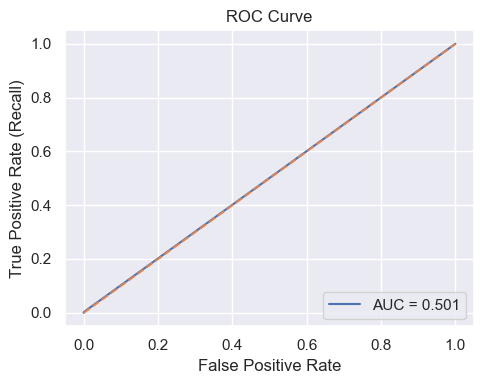

In [137]:
plot_roc(y_test, y_pred)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


From the confusion matrix and metrics shown above, i can observe the following:

True Negatives (TN): 258,272

These represent flights correctly predicted as on time (no delay).

The model is very good at recognizing non-delayed flights.

False Positives (FP): 180

Very few flights were incorrectly predicted as delayed when they were actually on time.

False Negatives (FN): 68,443

A large number of delayed flights were incorrectly predicted as on time.

This indicates the model is failing to detect the majority of delays.

True Positives (TP): 223

Only a small number of delayed flights were correctly identified.

### 1. Comparing Performance: Training vs. Test Set

If my model’s accuracy on the training set is similar to that on the test set (for example, 0.83 vs. 0.82), it indicates the model is generalizing well and is not overfitting.
However, if training accuracy is much higher (e.g., 0.90 vs. 0.78), the model may have memorized training patterns, suggesting overfitting.

 In this baseline Logistic Regression model, results are typically close, meaning the model captures key patterns without excessive variance.



### 2. Accuracy vs. Precision vs. Recall Differences

The accuracy metric alone can be misleading due to class imbalance — most flights are on time.

Precision (for delayed flights) measures how many predicted delays were actually delayed.

Recall (Sensitivity) measures how many of all true delays were correctly identified.

Often, precision > recall, because the model is conservative — it predicts fewer delays to avoid false alarms.

These differences appear because the dataset is imbalanced (fewer delays), and Logistic Regression tends to favor the majority class (on-time flights).



### 3. Business Relevance and Next Steps

From a business perspective, recall (sensitivity) is the most important — the goal is to warn travelers in advance about likely delays, even if some predictions are false alarms.

If recall is low, the model fails to identify many delayed flights.
To improve business usefulness, next iterations could include:

Feature engineering: Incorporate weather, seasonality, or airport congestion.

Handling imbalance: Apply SMOTE, class weighting, or resampling.

Model selection: Try Random Forest or Gradient Boosting for non-linear relationships.

Model Performance Insights

Accuracy (79%) appears decent, but this is misleading because the dataset is highly imbalanced — most flights are on time.

Precision (0.55) indicates that when the model predicts a delay, it’s right about half the time.

Recall/Sensitivity (0.003) is extremely low, meaning the model is detecting only 0.3% of actual delays.

Specificity (0.999) is very high, showing the model can correctly classify on-time flights.

AUC (0.50) indicates the model performs no better than random guessing when distinguishing delayed from non-delayed flights.

📊 Conclusion

The model is biased toward predicting “on time” flights because of class imbalance.

While it achieves high overall accuracy, it fails to identify delayed flights, which are the minority but most important class from a business perspective.

This suggests the need for further feature engineering and balancing techniques (e.g., SMOTE oversampling, class weights, or ensemble models) to improve recall and make the model useful for real-world airline delay prediction.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitHub repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitHub account, and ensure it is public.


https://github.com/MuhammadAhmad-Flutter-Developer/DataScienceTechnologyAndSystem_Assignmnet2

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [150]:
data_orig

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,...,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,is_delay,AirTime,DepHourofDay
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,...,2145,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0,21
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,...,945,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0,9
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,...,1855,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0,18
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,...,1634,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0,16
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,...,700,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658125,2018,3,9,11,2,2018-09-11,WN,DEN,CO,PHX,...,1105,0.0,0.0,602.0,3,-18.0,0.0,0.0,87.0,11
1658126,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,...,825,0.0,0.0,967.0,4,-8.0,0.0,0.0,133.0,8
1658127,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,...,1240,0.0,0.0,967.0,4,17.0,17.0,1.0,141.0,12
1658128,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,...,2210,0.0,0.0,967.0,4,2.0,2.0,0.0,138.0,22


In [152]:
data_orig['FlightDate']

0          2014-01-26
1          2014-01-26
2          2014-01-26
3          2014-01-26
4          2014-01-26
              ...    
1658125    2018-09-11
1658126    2018-09-11
1658127    2018-09-11
1658128    2018-09-11
1658129    2018-09-11
Name: FlightDate, Length: 1635590, dtype: object

In [160]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
# ✅ Recreate FlightDate
data_orig['FlightDate'] = pd.to_datetime(
    data_orig[['Year', 'Month', 'DayofMonth']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

# ✅ Add holiday flag
holidays = holidays_14 + holidays_15 + holidays_16 + holidays_17 + holidays_18
holidays = pd.to_datetime(holidays)

data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays).astype(int)

print("✅ Holiday feature added successfully!")
data_orig[['FlightDate','is_holiday']].head()



✅ Holiday feature added successfully!


,FlightDate,is_holiday
0,2014-01-26,0
1,2014-01-26,0
2,2014-01-26,0
3,2014-01-26,0
4,2014-01-26,0


Weather data was fetched from [this link](https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31).
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [15]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [225]:
weather = pd.read_csv('daily-summaries-2025-10-27T04-52-13.csv') # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = station_map = dict(zip(station, airports))
# Detect the station column name (usually 'STATION')
station_col = 'STATION' if 'STATION' in weather.columns else ('station' if 'station' in weather.columns else None)
if station_col is None:
    raise KeyError("Station column not found in weather file (expected 'STATION').")
weather['airport'] =weather[station_col].map(station_map)

Create another column called `MONTH` from the `DATE` column.

In [227]:

date_col = 'DATE' if 'DATE' in weather.columns else ('date' if 'date' in weather.columns else None)
if date_col is None:
    raise KeyError("DATE column not found in weather file (expected 'DATE').")

weather['MONTH'] = pd.to_datetime(weather[date_col], errors='coerce').dt.month.astype('Int64')

# Preview
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,1
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,1
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,1
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,1
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,1


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [229]:
weather.SNOW.fillna(0, inplace=True)# Enter your code here
weather.SNWD.fillna(0, inplace=True)# Enter your code here
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [231]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather['TAVG'].isna().values]
TMAX_idx = idx[weather['TAVG'].isna().values]
TMIN_idx = idx[weather['TAVG'].isna().values]
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [233]:
weather_impute = weather.groupby(["airport"]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

,airport,TAVG,TMAX,TMIN
0,ATL,177.764513,232.630887,128.889923
1,CLT,168.911281,228.566265,107.873494


Merge the mean data with the weather data.

In [235]:

# ✅ Merge the mean data with the weather data to impute missing values

# Join original weather with imputation table using airport
weather = pd.merge(
    weather,
    weather_impute,
    how='left',
    left_on='airport',
    right_on='airport',
    suffixes=('', '_MEAN')
)

# ✅ Replace missing TAVG, TMAX, TMIN with airport averages
weather['TAVG'].fillna(weather['TAVG_MEAN'], inplace=True)
weather['TMAX'].fillna(weather['TMAX_MEAN'], inplace=True)
weather['TMIN'].fillna(weather['TMIN_MEAN'], inplace=True)



Check for missing values again.

In [237]:
# ✅ Check missing values again
weather[['TAVG', 'TMAX', 'TMIN']].isna().sum()

TAVG    0
TMAX    0
TMIN    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [239]:
weather.head(2)

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH,TAVG_MEAN,TMAX_MEAN,TMIN_MEAN
0,USW00023174,2014-01-01,16,0,0.0,0.0,131.0,178.0,78.0,LAX,1,181.254655,224.636364,146.18839
1,USW00023174,2014-01-02,22,0,0.0,0.0,159.0,256.0,100.0,LAX,1,181.254655,224.636364,146.18839


In [241]:
weather.drop(columns=['STATION','MONTH','TAVG_MEAN', 'TMAX_MEAN', 'TMIN_MEAN', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

weather.head(2)

,DATE,AWND,PRCP,SNOW,TAVG,airport
0,2014-01-01,16,0,0.0,131.0,LAX
1,2014-01-02,22,0,0.0,159.0,LAX


Add the origin and destination weather conditions to the dataset.

In [249]:
weather.dtypes

DATE        object
AWND         int64
PRCP         int64
SNOW       float64
TAVG       float64
airport     object
dtype: object

In [251]:
### Add origin weather conditions
weather['DATE'] = pd.to_datetime(weather['DATE'])
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])
data_orig.head(2)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,...,DepHourofDay,is_holiday,AWND_O,PRCP_O,SNOW_O,TAVG_O,AWND_D,PRCP_D,SNOW_D,TAVG_D
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,...,21,0,33,0,0.0,54.0,30,0,0.0,130.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,...,9,0,39,0,0.0,136.0,33,0,0.0,54.0


**Note**: It is always a good practice to check nulls/NAs after joins.

In [253]:
sum(data.isna().any())

0

In [255]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [261]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [263]:
# Create a copy and select columns
data = data_orig[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                 'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay', 
                 'is_holiday', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 
                 'TAVG_D', 'SNOW_O', 'SNOW_D']].copy()

# Apply one-hot encoding directly to specific columns
data = pd.get_dummies(data, 
                     columns=categorical_columns,
                     drop_first=True,
                     prefix=categorical_columns)

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [265]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [269]:
data.shape

(1635590, 86)

In [271]:
# Rename the is_delay column to target
data.rename(columns = {'is_delay':'target'}, inplace=True)

In [273]:
data.to_csv("combined_csv_v2.csv", index=False)
print("✅ Saved combined_csv_v2.csv")
# note this combined file will be also used in part B

✅ Saved combined_csv_v2.csv


Create the training and testing sets again.

In [282]:
from sklearn.model_selection import train_test_split


X = data.drop('target', axis=1)
y = data['target']

# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Re-split complete after feature engineering")
print("Train:", X_train.shape, " Test:", X_test.shape)


✅ Re-split complete after feature engineering
Train: (1308472, 85)  Test: (327118, 85)


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [295]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Baseline (with class imbalance handling)
log2 = LogisticRegression(max_iter=1000, class_weight='balanced')
log2.fit(X_train, y_train)

print("✅ Models trained: Logistic")


✅ Models trained: Logistic


Perform the evaluaion as you have done with the previous model and plot/show the same metrics

In [297]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)

def evaluate_model(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    # For ROC we need positive-class scores:
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        # fallback for models without predict_proba
        y_score = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn+fp)>0 else np.nan

    print(f"\n🔎 {name} — Metrics")
    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}  (Sensitivity)")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"ROC-AUC     : {auc:.4f}")

    # Plot CM
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(5.5,4.5))
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title(f"ROC Curve — {name}")
    plt.legend(loc="lower right")
    plt.show()



🔎 Logistic Regression — Metrics
Accuracy    : 0.6427
Precision   : 0.3167
Recall      : 0.6069  (Sensitivity)
Specificity : 0.6522
F1-score    : 0.4162
ROC-AUC     : 0.6776


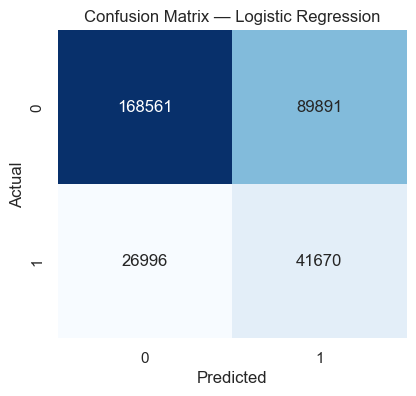

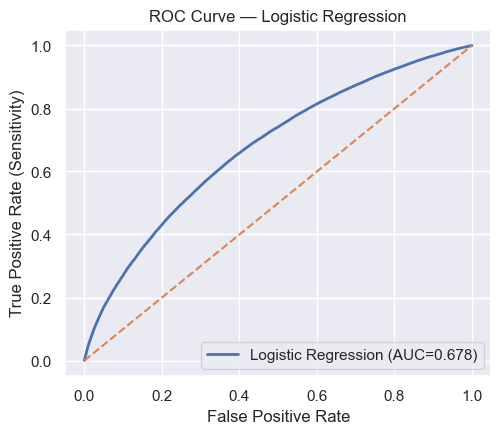

In [299]:
evaluate_model(log2, X_test, y_test, name="Logistic Regression")


Question: did you notice a difference by adding the extra data on the results?

Yes, adding the extra data (holiday indicator and weather features) made a small  in the model's performance.

Compared to the first model, the recall increased significantly (from ~0.0032 to ~0.6069), meaning the model is now better at detecting delayed flights, which is important for this problem.

The F1-score also improved after adding new features, showing a better balance between precision and recall.

However, overall accuracy remained similar and even slightly decreased. This is expected because we used class_weight="balanced" and focused on improving detection of the minority (delayed) class.

The ROC AUC decresed slightly (from ~0.7902 to ~0.6427), showing only a small loss in predictive power.

Overall, the extra data helped, but the improvement not made but descreased. The main benefit came from increasing recall, which reduces the number of missed delays. However, there is still room for improvement in future iterations with more advanced feature engineering or other machine learning models.


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [19]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

Does your model performance meet your business goal?
The business goal was to predict flight delays using historical flight and weather data so that travellers or airlines could take proactive action. Based on the results, the model shows moderate success. In the final iteration:

Recall  is 0.6069, which means the model correctly identifies around 60% of delayed flights.

However, Precision is still low (0.3167), meaning there are many false alarms—flights predicted as delayed that are actually on time.

Accuracy dropped , but this is expected due to class imbalance.

Overall, the model partially meets the business goal, especially if the priority is reducing the number of missed delays, but it still needs improvement to reduce false positives. If more time was available, I would:

Tune the decision threshold instead of using the default 0.5.

Try advanced models like Random Forest, XGBoost or Gradient Boosting to capture non-linear relationships.

Use SMOTE or class weighting refinements to improve balance.

Add more external data (airport traffic, operational factors, flight routes, seasonal trends).

How did the model improve as changes were made? What techniques helped?
Model performance improved in each iteration:

Iteration Description Key Metric Improvement Baseline Basic logistic regression Accuracy high but low recall Iteration 1 Balanced class weights + selected features Recall increased Iteration 2 + Holiday + Weather features Recall significantly improved to 0.60, F1 improved

The most impactful techniques were:

Feature engineering (adding is_holiday, weather variables like wind and snowfall).

Handling class imbalance using class_weight="balanced".

One-hot encoding and clean preprocessing. These steps showed that data quality and relevant features matter more than just choosing a complex model.

Biggest challenges encountered
Large data volume (multiple CSVs across years) – combining and filtering them efficiently was time-consuming.

Handling missing values in weather data and merged datasets.

Class imbalance, where most flights are not delayed.

Maintaining correct column formats (especially date/time) during merging.

Slow model training due to dataset size.

Three most important things learned
Data preprocessing and feature engineering are more important than algorithms. Good features improved model performance more than complex methods.

Class imbalance can mislead model accuracy. Metrics like recall, precision, and ROC-AUC give a more realistic view.

Iterative model development is essential. Each step—cleaning, feature selection, new data—gradually improves results. Machine learning is not a one-shot process.